In [5]:
pip install pyarrow cairosvg

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import cv2
import requests
import os
import sqlite3
import cairosvg  # For converting SVG to PNG
from skimage import io
from urllib.parse import urlparse, urljoin
from datetime import datetime
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import concurrent.futures
from functools import partial
import logging

In [2]:
# Headers to mimic a real browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

In [3]:
df = pd.read_parquet("extracted_logos.parquet")
print(df.head())

                                    site  \
0  mazda-autohaus-hellwig-hoyerswerda.de   
1                    plameco-hannover.de   
2                           ibc-solar.jp   
3                          synlab.com.tr   
4            autosecuritas-ct-seysses.fr   

                                            logo_url  
0  https://www.assets.mazda-autohaus.de/assets/im...  
1  https://www.plameco-hannover.de/domains/plamec...  
2  https://ibc-solar.jp/config/Resources/images/i...  
3       https://synlab.com.tr/images/header-logo.svg  
4  https://autosecuritas-ct-seysses.fr/public/img...  


In [4]:

# Get the current working directory \
LOG_FILE_PATH = os.path.join(os.getcwd(), "preprocess_project_log.txt")

# Configure logging to avoid PermissionError in multi-threading
logging.basicConfig(
    filename=LOG_FILE_PATH,
    level=logging.INFO,
    format="%(asctime)s : %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

def log_progress(message):
    """ Logs a message safely (thread-safe). """
    logging.info(message)
    print(f"[{datetime.now()}] {message}")


In [5]:
def analyze_and_plot_url_types(parquet_file):
    """
    Analyzes the types of URLs in a given Parquet file and plots their distribution.

    Parameters:
    - parquet_file (str): Path to the Parquet file containing logo URLs.

    Returns:
    - DataFrame with counts of different URL types.
    """
    # Load the dataset
    df = pd.read_parquet(parquet_file)

    # Extract the scheme (http, https, data, etc.) from each URL
    df["url_scheme"] = df["logo_url"].apply(lambda x: urlparse(x).scheme if pd.notna(x) else "unknown")

    # Count occurrences of each URL type
    url_type_counts = df["url_scheme"].value_counts().reset_index()
    url_type_counts.columns = ["URL Type", "Count"]

    # Plot the distribution
    plt.figure(figsize=(10, 5))
    bars = plt.bar(url_type_counts["URL Type"], url_type_counts["Count"], color='skyblue', edgecolor='black')

    # Annotate bars with the count values
    for bar, count in zip(bars, url_type_counts["Count"]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Set labels and title
    plt.xlabel("URL Type")
    plt.ylabel("Count")
    plt.title("Distribution of URL Types in Extracted Logos")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.show()

    return url_type_counts


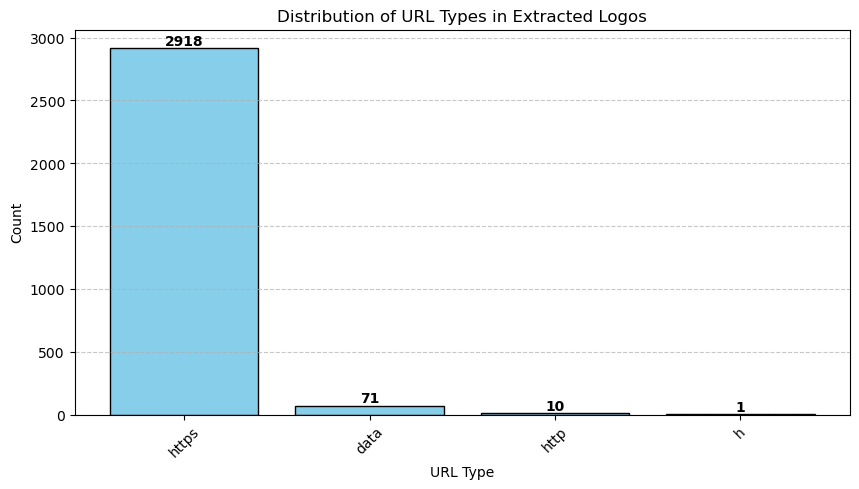

In [6]:
url_stats = analyze_and_plot_url_types("extracted_logos.parquet")

In [7]:
def convert_svg_to_png_bytes(svg_data):
    """
    Converts an inline SVG data URI to PNG bytes.

    Parameters:
    - svg_data (str): The SVG data URI.

    Returns:
    - PNG bytes if conversion is successful, otherwise None.
    """
    try:
        # Remove the prefix and URL-decode the SVG content
        svg_content = svg_data.split(",")[1]
        svg_content = requests.utils.unquote(svg_content)

        # Convert SVG to PNG bytes using cairosvg
        png_bytes = cairosvg.svg2png(bytestring=svg_content.encode("utf-8"))
        return png_bytes
    except Exception as e:
        log_progress(f" Error converting SVG: {e}")
        return None

In [8]:

# Function to process and download images, including SVGs and WebP formats.
def preprocess_and_download_image(img_url):
    """
    Downloads an image and applies preprocessing:
      - Handles inline SVGs (`data:image/svg+xml`).
      - Converts external SVGs (`.svg` URLs) to PNG.
      - Downloads and processes WebP images properly.
      - Skips favicons that are too small (<32x32).
      - Upscales valid favicons (e.g., `32x32`, `64x64`) to `224x224`.
      - Converts image to LAB space and applies CLAHE for contrast enhancement.
      - Returns processed PNG bytes.
      
    Returns:
    - Processed image as PNG bytes if successful, otherwise None.
    """
    try:
        # Skip inline SVGs
        if img_url.startswith("data:image/svg+xml"):
            log_progress(f"Skipping inline SVG: {img_url[:50]}...")
            return None

        # Process external SVGs (`.svg` URLs)
        if urlparse(img_url).path.lower().endswith(".svg"):
            response = requests.get(img_url, headers={"User-Agent": "Mozilla/5.0"}, timeout=20)
            if response.status_code != 200:
                log_progress(f" Error downloading external SVG: {img_url}")
                return None
            
            # Ensure UTF-8 encoding and ignore encoding errors
            svg_data = response.text.encode("utf-8", errors="ignore").decode("utf-8", errors="ignore")

            # Convert SVG to PNG bytes
            png_bytes = cairosvg.svg2png(bytestring=svg_data.encode("utf-8"))
            nparr = np.frombuffer(png_bytes, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        else:
            # Download the image from the URL
            response = requests.get(img_url, headers={"User-Agent": "Mozilla/5.0"}, timeout=20)
            if response.status_code != 200:
                log_progress(f" Error downloading image: {img_url}")
                return None

            # Validate if response is an actual image
            content_type = response.headers.get("Content-Type", "")
            if "image" not in content_type:
                log_progress(f" Error - Not an image: {img_url}")
                return None

            # Handle WebP images separately
            if "webp" in content_type:
                img = Image.open(BytesIO(response.content))
                img = img.convert("RGB")  # Convert WebP to RGB
                img = np.array(img)  # Convert to NumPy array for OpenCV
            else:
                # Decode the image using OpenCV
                nparr = np.frombuffer(response.content, np.uint8)
                img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # Ensure the image is valid before proceeding
        if img is None or img.size == 0:
            log_progress(f" Decoded image is invalid: {img_url}")
            return None

        # Ensure image has at least 2 dimensions
        if len(img.shape) < 2:
            log_progress(f"Image has incorrect shape: {img.shape}")
            return None

        # Handle Favicons (Skip tiny ones, upscale small but valid ones)
        height, width = img.shape[:2]
        if height < 32 or width < 32:
            log_progress(f" Skipping tiny favicon: {img_url} ({width}x{height})")
            return None

        if height < 128 or width < 128:
            log_progress(f" Upscaling small favicon: {img_url} ({width}x{height}) → (224x224)")
            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)

        # Resize the image to 224x224 using cubic interpolation
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)

        # Ensure image is in RGB format
        if len(img_resized.shape) == 2 or img_resized.shape[2] == 1:
            img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

        # Convert RGB to LAB color space
        lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)

        # Merge back the LAB channels and convert to RGB
        lab_clahe = cv2.merge((l_clahe, a, b))
        img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

        # Encode the processed image as PNG bytes
        success, encoded_image = cv2.imencode('.png', img_clahe)
        if success:
            return encoded_image.tobytes()
        else:
            return None

    except requests.exceptions.RequestException as e:
        log_progress(f" Request error: {e}")
    except Exception as e:
        log_progress(f" Unknown error: {e}")

    return None


In [9]:
# Initialize database and clear existing records
def init_and_clear_db(db_path):
    """
    Initializes a SQLite database and clears any existing stored images.

    Parameters:
    - db_path (str): Path to the SQLite database file.

    Returns:
    - SQLite connection object.
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS logos (
            site TEXT PRIMARY KEY,
            processed_image BLOB
        )
    """)
    cursor.execute("DELETE FROM logos")  #  Clear all existing records
    conn.commit()
    return conn

In [10]:
# Function to process a single image and store it in the database
def process_single_image(row, db_path):
    """
    Processes a single image and stores it in the SQLite database.

    Parameters:
    - row (pd.Series): A row from the DataFrame containing 'site' and 'logo_url'.
    - db_path (str): Path to the SQLite database.

    Returns:
    - Tuple (site, processed_image_bytes) if successful, else None.
    """
    site = row["site"]
    img_url = row["logo_url"]

    log_progress(f"Processing {site} - URL: {img_url}")
    processed_bytes = preprocess_and_download_image(img_url)

    if processed_bytes is not None:
        return (site, processed_bytes)
    else:
        log_progress(f"Skipping site {site} due to processing error.")
        return None



In [11]:
# Main function: Process images from the Parquet file using multithreading
def process_images_and_store(parquet_file, db_path, max_threads=20):
    """
    Processes images from the given Parquet file using multithreading and stores them in a SQLite database.

    Parameters:
    - parquet_file (str): Path to the input Parquet file containing logo URLs and site names.
    - db_path (str): Path to the SQLite database file.
    - max_threads (int): Number of threads for parallel processing.
    """
    # Load dataset
    df = pd.read_parquet(parquet_file, engine="pyarrow")
    total_sites = len(df)  # Total number of sites in dataset
    log_progress(f" Loaded {total_sites} rows from {parquet_file}")

    # Initialize & clear database
    conn = init_and_clear_db(db_path)
    cursor = conn.cursor()

    # Process images in parallel
    processed_results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_threads) as executor:
        process_func = partial(process_single_image, db_path=db_path)
        for result in executor.map(process_func, [row for _, row in df.iterrows()]):
            if result is not None:
                processed_results.append(result)

    # Bulk insert processed images into database for efficiency
    stored_images = len(processed_results)  # Number of successfully processed images
    if processed_results:
        cursor.executemany("INSERT OR REPLACE INTO logos (site, processed_image) VALUES (?, ?)", processed_results)
        conn.commit()
        log_progress(f" Stored {stored_images} images in database.")

    # Close DB connection
    conn.close()

    #  Final statistics
    success_rate = (stored_images / total_sites) * 100 if total_sites > 0 else 0
    log_progress("\n FINAL STATISTICS:")
    log_progress(f" Total sites processed: {total_sites}")
    log_progress(f" Images successfully stored: {stored_images}")
    log_progress(f" Failed to process: {total_sites - stored_images}")
    log_progress(f" Success Rate: {success_rate:.2f}%")

    log_progress(" Processing complete!")

[2025-03-18 14:07:19.182259]  Loaded 3000 rows from extracted_logos.parquet
[2025-03-18 14:07:19.566257] Processing mazda-autohaus-hellwig-hoyerswerda.de - URL: https://www.assets.mazda-autohaus.de/assets/img/favicons/favicon-32x32.png
[2025-03-18 14:07:19.566257] Processing plameco-hannover.de - URL: https://www.plameco-hannover.de/domains/plameco-hannover.de/media/DE_Plameco_Logo.png
[2025-03-18 14:07:19.566257] Processing ibc-solar.jp - URL: https://ibc-solar.jp/config/Resources/images/ibclogo.svg
[2025-03-18 14:07:19.566257] Processing synlab.com.tr - URL: https://synlab.com.tr/images/header-logo.svg
[2025-03-18 14:07:19.566257] Processing autosecuritas-ct-seysses.fr - URL: https://autosecuritas-ct-seysses.fr/public/img/member-site-v2/logo/autosecuritas-logo.svg
[2025-03-18 14:07:19.578854] Processing toyota-buchreiter-eisenstadt.at - URL: https://www.toyota-buchreiter-eisenstadt.at/images/Toyota_Logo.svg
[2025-03-18 14:07:19.583849] Processing wurthsaudi.com - URL: https://wurthsa
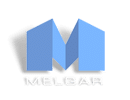
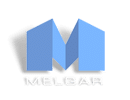
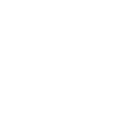
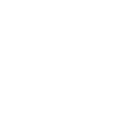
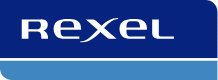
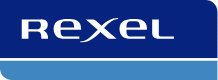
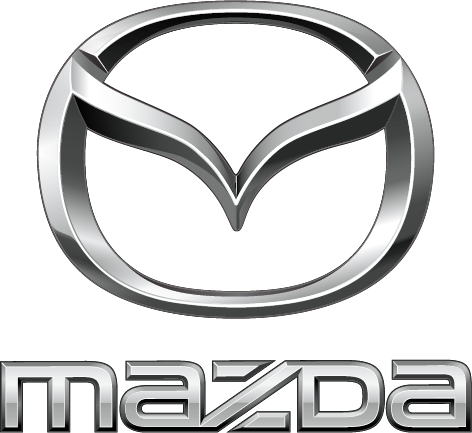
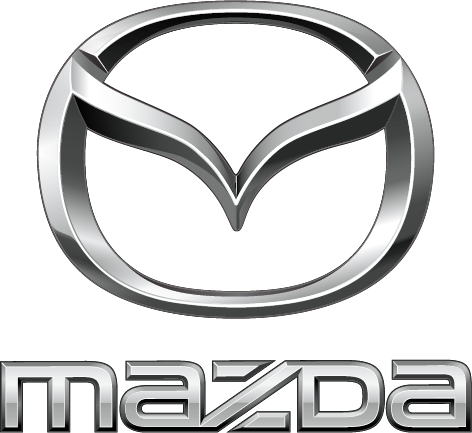
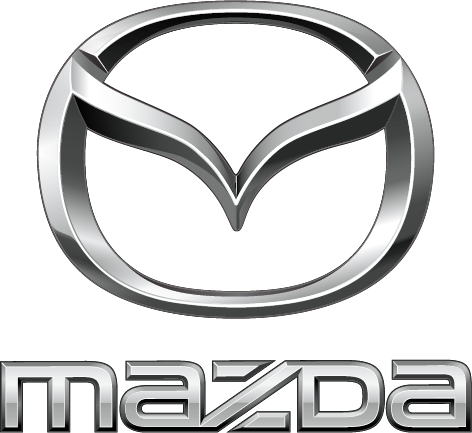
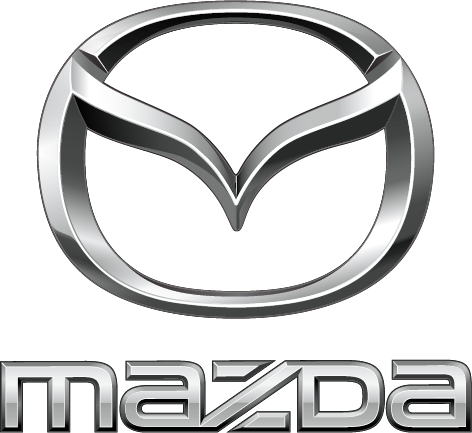
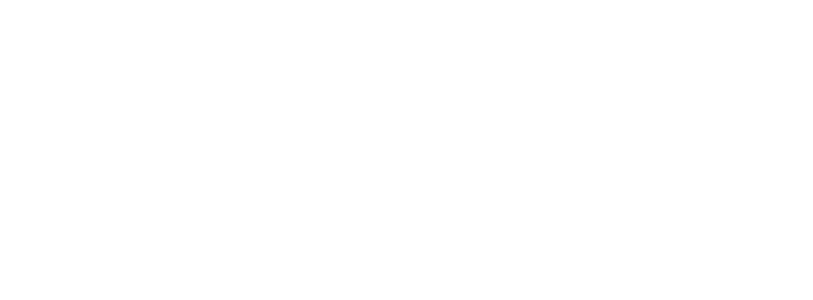
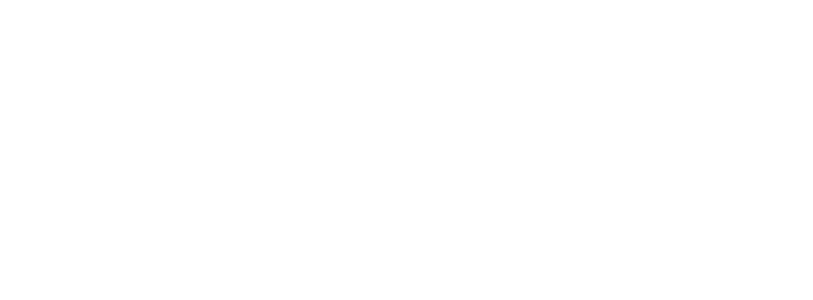

In [12]:
process_images_and_store("extracted_logos.parquet", "processed_logos.db", max_threads=30)

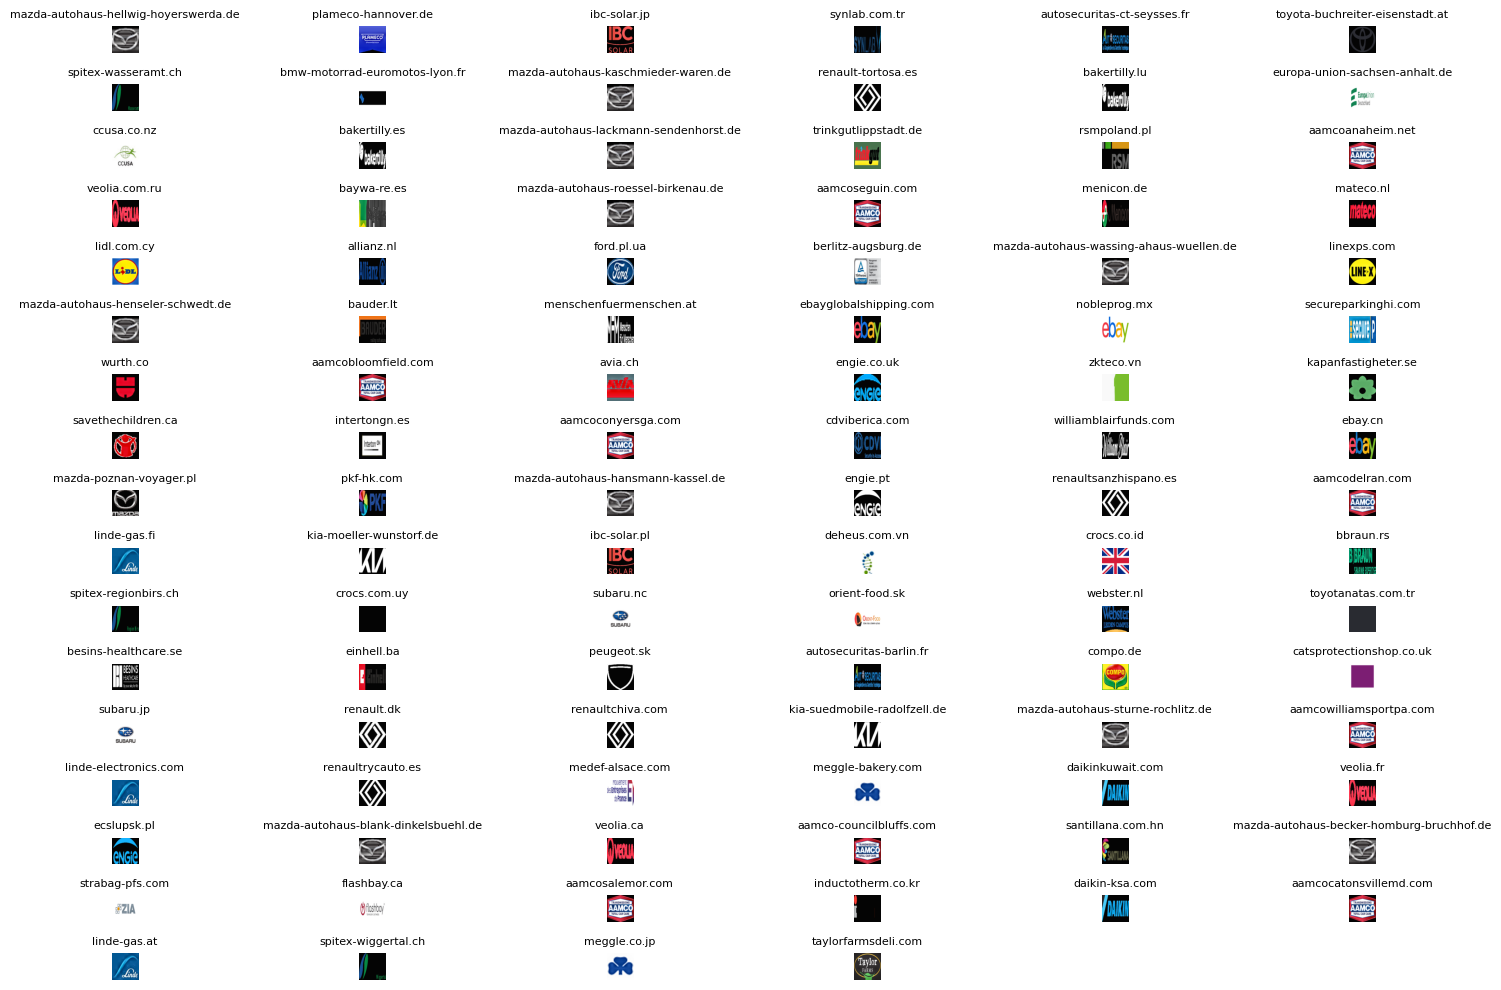

In [13]:

def show_first_n_images_from_db(db_path, n=30):
    """
    Retrieves and displays the first `n` images stored in the SQLite database.

    Parameters:
    - db_path (str): Path to the SQLite database file.
    - n (int): Number of images to display (default: 30).
    """
    # Connect to the database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Retrieve the first `n` images
    cursor.execute("SELECT site, processed_image FROM logos LIMIT ?", (n,))
    rows = cursor.fetchall()
    conn.close()  # Close DB connection

    if not rows:
        print(" No images found in the database.")
        return

    # Create a plot grid (e.g., 5x6 for 30 images)
    cols = 6
    rows_count = (n // cols) + (1 if n % cols else 0)
    fig, axes = plt.subplots(rows_count, cols, figsize=(15, 10))
    axes = axes.ravel()

    # Display each image
    for i, (site, img_bytes) in enumerate(rows):
        if img_bytes:
            # Convert binary data to OpenCV image
            nparr = np.frombuffer(img_bytes, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
                axes[i].imshow(img_rgb)
                axes[i].set_title(site, fontsize=8)
                axes[i].axis("off")
            else:
                print(f" Error decoding image for site: {site}")

    # Remove any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
show_first_n_images_from_db("processed_logos.db", n=100)

